In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import warnings
import pandas as pd
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
from get_dataset import synthetic

from model import MCLogisticRegression 
from fairlearn.metrics import equalized_odds_difference
from fairlearn.metrics import demographic_parity_difference

In [2]:
#Federated Learning.
sf_rate_list = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8, 0.9, 1]
FL_ACC = []
FL_EO = []
FL_DP = []

for sf_rate in sf_rate_list:
    synthetic_ = synthetic(sf_rate=sf_rate, num_data=100)
    X_user, y_user, X_all, y_all, user_list, user_id, sf_all = synthetic_.getData()
    
    testing_acc = []
    iteration = 5
    fedavg_weight = None
    fedavg_intercept = None

    fedavg_eod = []
    fedavg_dpr = []

    for i in range(iteration):
        weights = []
        intercepts = []
        each_testing_acc = []
        so_eod = []
        so_dpr = []
        
        for user in user_list:
            X = np.array(X_user[user])
            sf_indices = np.where(np.array(user_id) == user)
            sf = sf_all[sf_indices]
            y = y_user[user]
            
            X_train, X_test, y_train, y_test, _, sf_test= \
                                    train_test_split(X, y, sf, test_size=0.3)
            model = MCLogisticRegression(X_train, y_train, X_test, y_test, 
                                        0.01, 50, 2, fedavg_weight, 
                                        fedavg_intercept)
            model.train()
            y_pred = model.predict(X_test)
            acc = np.mean(y_pred == y_test)
            weights.append(model.w.tolist())
            intercepts.append(model.b.tolist())
            each_testing_acc.append(acc)
            
            #Calculate OE and DP
            eod_race = equalized_odds_difference(y_test, y_pred, sensitive_features=sf_test)
            dpr_race = demographic_parity_difference(y_test, y_pred, sensitive_features=sf_test)
            
            #Store OE and DP for each state.
            so_eod.append(eod_race)
            so_dpr.append(dpr_race)
        #print("iteration", i)
        
        #mean of weights and update the fedavg weights and intercept
        fedavg_weight = np.array(weights).mean(axis=0)
        fedavg_intercept = np.array(intercepts).mean()
        testing_acc.append(np.mean(each_testing_acc))
        
        #mean of EO and DP for all states.
        fedavg_eod.append(np.mean(so_eod))
        fedavg_dpr.append(np.mean(so_dpr))
      
    FL_ACC.append(testing_acc[-1])
    FL_EO.append(fedavg_eod[-1])
    FL_DP.append(fedavg_dpr[-1])
    print("sf_rate", sf_rate)

sf_rate 0
sf_rate 0.1
sf_rate 0.2
sf_rate 0.3
sf_rate 0.4
sf_rate 0.5
sf_rate 0.6
sf_rate 0.7
sf_rate 0.8
sf_rate 0.9
sf_rate 1


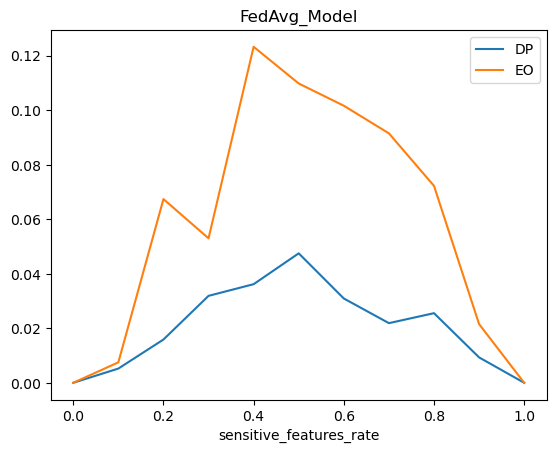

In [3]:
plt.plot(sf_rate_list, FL_DP, label="DP")
plt.plot(sf_rate_list ,FL_EO, label="EO")
plt.xlabel("sensitive_features_rate")
plt.title("FedAvg_Model")
plt.legend()
plt.show()

In [7]:
#Centralized Model
sf_rate_list = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8, 0.9, 1]
Centralized_ACC = []
Centralized_EO = []
Centralized_DP = []

for sf in sf_rate_list:
    synthetic_ = synthetic(sf_rate=sf, num_data=1000)
    X_user, y_user, X_all, y_all, user_list, user_id, sf_all = synthetic_.getData()

    from sklearn.linear_model import LogisticRegression

    X_train, X_test, y_train, y_test, _, sf_test = \
                    train_test_split(X_all, y_all, sf_all, test_size=0.3)
                    
    clf = LogisticRegression().fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)

    eod = equalized_odds_difference(y_test, y_test_pred, sensitive_features=sf_test)
    dpr = demographic_parity_difference(y_test, y_test_pred, sensitive_features=sf_test)
    
    Centralized_ACC.append(clf.score(X_test,y_test))
    Centralized_EO.append(eod)
    Centralized_DP.append(dpr)
    print(sf, np.mean(sf_all))

0 0.0
0.1 0.100006508419105
0.2 0.20000371909663142
0.3 0.3000009297741579
0.4 0.3999981404516843
0.5 0.49999535112921073
0.6 0.6000018595483158
0.7 0.6999990702258422
0.8 0.7999962809033686
0.9 0.899993491580895
1 0.9999907022584215


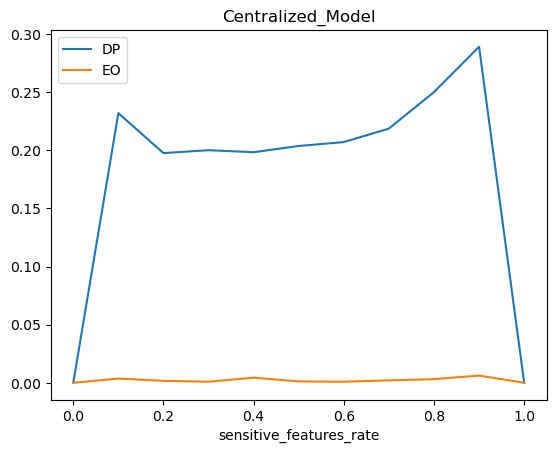

In [8]:
# plt.plot(Centralized_ACC)
# plt.plot(Centralized_EO)
# plt.plot(Centralized_DP)

plt.plot(sf_rate_list ,Centralized_DP, label="DP")
plt.plot(sf_rate_list, Centralized_EO, label="EO")
plt.xlabel("sensitive_features_rate")
plt.title("Centralized_Model")
plt.legend()
plt.show()